In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np
#import matplotlib as mpl
import cv2  # conda install -c conda-forge opencv
from moviepy.editor import VideoFileClip
from moviepy.editor import *

#%matplotlib notebook
import matplotlib.pyplot as plt
#%matplotlib notebook

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['axes.grid'] = False
#plt.style.use('dark_background')
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 15
#!pip install ipympl
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
vid_path = "./data/videos/individual-rotifer/"
vid_filename = "2024_0201_152845_091.MP4"  # d_unclear
vid_filepath = f"{vid_path}{vid_filename}"
PROCESS_VIDEO = False
SAVE_VIDEO = False
SHOW_VIDEO = False
print(vid_filepath)

#1:43-1:50
trim_start = 105#103# 
trim_end = 109#110
trim_duration = trim_end - trim_start
trim_vid_filepath = f"{vid_path}{vid_filename.split('.')[0]}_subclip_{trim_duration}sec_ts{trim_start}-te{trim_end}.mp4"

if PROCESS_VIDEO:
    video_clip = VideoFileClip(vid_filepath).subclip(trim_start, trim_end)
    duration = video_clip.duration
    resolution = video_clip.size
    fps = video_clip.fps

    print(duration, fps, resolution)
    if SAVE_VIDEO:
        video_clip.write_videofile(f"{vid_path}{vid_filename.split('.')[0]}_subclip_{trim_duration}sec_ts{trim_start}-te{trim_end}.mp4",
                                    fps=fps, codec="libx264", audio=False)
    video_clip.close()

./data/videos/individual-rotifer/2024_0201_152845_091.MP4


2160 2880


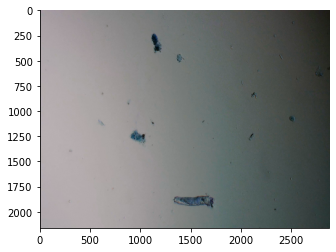

In [3]:
trim_vid_filepath = f"{vid_path}{vid_filename.split('.')[0]}_subclip_{trim_duration}sec_ts{trim_start}-te{trim_end}.mp4"
SHOW_FRAME = True
if SHOW_FRAME:

    cap = cv2.VideoCapture(trim_vid_filepath)
    ret, frame = cap.read()
    height, width, _ = frame.shape
    print(height, width)

    plt.figure()
    plt.imshow(frame)
    #plt.imshow(frame[100:900, 1100:1500])

In [4]:
SAVE_VIDEO = False
trim_crop_vid_filepath = f"{vid_path}{vid_filename.split('.')[0]}_subclip_{trim_duration}sec_ts{trim_start}-te{trim_end}_cropped.mp4"
if SAVE_VIDEO:
    # trim video path > load in 
    video_clip = VideoFileClip(trim_vid_filepath)
    video_crop = video_clip.fx(vfx.crop, x1=0, x2=2880, y1=1000, y2=2160) #
    video_crop.write_videofile(trim_crop_vid_filepath, fps=fps, codec="libx264", audio=False)
    video_crop.close()
    video_clip.close()

# IDEE
- use segmasks to rotate everything to middle and then write out as a video, then use that video to segment again, to get the antenae clean!
- First load in and rotate video according to the mask and make a cut out, then again to segmentation

# Analysis

In [5]:
trim_crop_vid_filename = f"{vid_filename.split('.')[0]}_subclip_{trim_duration}sec_ts{trim_start}-te{trim_end}_cropped.mp4"
vid_extension = "." + trim_crop_vid_filename.split(".")[-1]
vid_filename = trim_crop_vid_filename.split(".")[0]


vid_filepath = f"{vid_path}{vid_filename}{vid_extension}"
seg_mask_path = f"./data/results/{vid_filename}_masks" 

video = cv2.VideoCapture(vid_filepath)
fps = int(video.get(cv2.CAP_PROP_FPS))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
resolution = (height,width)
video.release()
print(fps, resolution)

24 (1160, 2880)


# Frame extraction

In [6]:
EXTRACT_FRAMES = False
frames_filepaths = f"./data/images/{vid_filename}/"
zfill_ = 5  # correspond to seg-masks

if EXTRACT_FRAMES:
    os.makedirs(frames_filepaths, exist_ok=True)
    video = cv2.VideoCapture(vid_filepath)
    frame_counter = 0
    while True:
        ret, frame = video.read()
        if not ret:
            break
        if frame_counter % 1 == 0:
            cv2.imwrite(f"{frames_filepaths}/frame_{str(frame_counter).zfill(zfill_)}.jpg", frame)  
        frame_counter += 1
    video.release()

In [7]:
# Construct output figure path
save_figure_path = "_".join(seg_mask_path.split("_")[:-1])
os.makedirs(save_figure_path, exist_ok=True)
save_figure_path = os.path.join(save_figure_path, vid_filename)

### Get Segmentation Mask and video properties

In [14]:
# Get Segmentation masks > results of tracking 
mask_filenames = sorted([f for f in os.listdir(seg_mask_path) if f.endswith("png")])
mask_filepaths = [os.path.join(seg_mask_path, fn) for fn in mask_filenames]

# Construct the dataframe
frames = np.linspace(0, len(mask_filepaths), len(mask_filepaths)).astype("int")
df = pd.DataFrame(frames, columns=["frame"])
df["time"] = np.linspace(0, len(df) / fps, len(df))
df["mask_fpath"] = mask_filepaths

num_frames = len(df)
print("num_frames:", num_frames, "; save_figure_path:", save_figure_path, "; fps:", fps, "; resolution:", resolution)

# Adjust resolution depending on frame rate
if fps == 24:
    pixel_per_real_width = .4 # 2.5
    print("UHD, pixel_per_real_width = ", pixel_per_real_width)
elif fps == 60 or fps == 30:
    pixel_per_real_width = .61 # 1.65
    print("FHD, pixel_per_real_width = ", pixel_per_real_width)

# Load in the segmentation masks and find contrours
from utils import get_contours_from_segmasks, get_contour_stats
segmentation_mask_filepaths = df["mask_fpath"].tolist()

frame_idx = 57 # 128
contour_list = get_contours_from_segmasks(segmentation_mask_filepaths[:frame_idx])
#contour_list = get_contours_from_segmasks(segmentation_mask_filepaths[:68])

# Get contour stats
df_ = get_contour_stats(contour_list) # add xtime but beware of NaN???!!! if area <5

# Concat dfs
df = pd.concat([df, df_], axis=1)
df["img_fpath"] = [f"{frames_filepaths}frame_{str(nth).zfill(zfill_)}.jpg" for nth in range(len(df))]

# Mark frames for subsampling
every_nth_frame = int(fps/2) # subsampling of frames to illustrate
frame_subsample = np.arange(0, num_frames, every_nth_frame)
df["frame_shown"] = 0
df.loc[frame_subsample, "frame_shown"] = 1

# For Visualization of all and subsample
desired_cmap = "brg"
cmap = plt.get_cmap(desired_cmap)
colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(df))]
sub_colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(frame_subsample))]
sub_index = np.arange(0, len(frame_subsample), 1)

# Check df
df.head(5)

num_frames: 96 ; save_figure_path: ./data/results/2024_0201_152845_091_subclip_4sec_ts105-te109_cropped/2024_0201_152845_091_subclip_4sec_ts105-te109_cropped ; fps: 24 ; resolution: (1160, 2880)
UHD, pixel_per_real_width =  0.4


,frame,time,mask_fpath,centroid_x,centroid_y,area,min_area,extent,perimeter,aspect_ratio,orientation,centroid_dist,img_fpath,frame_shown
0,0,0.000000,./data/results/2024_0201_152845_091_subclip_4s...,1542.0,890.0,33107.5,55440.0,0.597177,1017.286358,2.828571,91.997978,NaN,./data/images/2024_0201_152845_091_subclip_4se...,1
1,1,0.042105,./data/results/2024_0201_152845_091_subclip_4s...,1563.0,913.0,34233.5,61353.0,0.557976,1047.570628,2.620915,93.704185,31.144823,./data/images/2024_0201_152845_091_subclip_4se...,0
2,2,0.084211,./data/results/2024_0201_152845_091_subclip_4s...,1444.0,949.0,34644.5,61712.0,0.561390,1040.399056,2.671053,95.177597,124.326184,./data/images/2024_0201_152845_091_subclip_4se...,0
3,3,0.126316,./data/results/2024_0201_152845_091_subclip_4s...,1484.0,959.0,34201.0,59568.0,0.574151,1031.813270,2.794521,97.186333,41.231056,./data/images/2024_0201_152845_091_subclip_4se...,0
4,4,0.168421,./data/results/2024_0201_152845_091_subclip_4s...,1533.0,974.0,34248.5,62928.0,0.544249,1032.055911,2.723684,98.521469,51.244512,./data/images/2024_0201_152845_091_subclip_4se...,0


In [15]:
df = df[:frame_idx]

In [16]:
df.tail(5)

,frame,time,mask_fpath,centroid_x,centroid_y,area,min_area,extent,perimeter,aspect_ratio,orientation,centroid_dist,img_fpath,frame_shown
52,52,2.189474,./data/results/2024_0201_152845_091_subclip_4s...,1822.0,304.0,36013.5,67144.0,0.536362,1091.796025,2.831169,80.582451,82.389320,./data/images/2024_0201_152845_091_subclip_4se...,0
53,53,2.231579,./data/results/2024_0201_152845_091_subclip_4s...,1900.0,299.0,35876.5,58387.0,0.614460,1076.541192,3.300752,84.349236,78.160092,./data/images/2024_0201_152845_091_subclip_4se...,0
54,54,2.273684,./data/results/2024_0201_152845_091_subclip_4s...,1981.0,294.0,36208.5,57792.0,0.626531,1095.286359,3.472868,85.597527,81.154174,./data/images/2024_0201_152845_091_subclip_4se...,0
55,55,2.315789,./data/results/2024_0201_152845_091_subclip_4s...,2067.0,288.0,37782.0,61640.0,0.612946,1116.700573,3.432836,85.650826,86.209048,./data/images/2024_0201_152845_091_subclip_4se...,0
56,56,2.357895,./data/results/2024_0201_152845_091_subclip_4s...,2147.0,280.0,37752.5,64960.0,0.581165,1127.771640,3.314286,84.332985,80.399005,./data/images/2024_0201_152845_091_subclip_4se...,0


## Immediately rotate and show those rotated only!!! makes everything clearer

In [17]:
df["centroid_y"].unique()

array([ 890.,  913.,  949.,  959.,  974.,  986.,  996.,  979.,  988.,
       1001., 1006., 1009., 1013., 1019., 1025.,  745.,  636.,  638.,
        635.,  551.,  413.,  354.,  297.,  261.,  231.,  208.,  189.,
        241.,  424.,  488.,  495.,  503.,  510.,  471.,  475.,  480.,
        485.,  476.,  473.,  468.,  460.,  447.,  432.,  414.,  395.,
        376.,  356.,  339.,  312.,  304.,  299.,  294.,  288.,  280.])

In [ ]:
rot_imgs = []
rot_masks = []
rot_contours = []

for nth, row in df.iterrows():
    # Img
    cimg = cv2.cvtColor(cv2.imread(row["img_fpath"], 1), cv2.COLOR_BGR2RGB)
    # Mask
    cmask = cv2.cvtColor(cv2.imread(row["mask_fpath"], 1), cv2.COLOR_BGR2GRAY)
    
    # Rotate
    h, w = cimg.shape[:2]
    center = (w/2, h/2)
    center = (row["centroid_x"], row["centroid_y"])
    angle = row["orientation"]  # fitted ellipse angle
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)

    # Rotate img, mask
    tmp_img = cv2.warpAffine(src=cimg, M=rotate_matrix, dsize=(w, h))
    #rot_imgs.append(cv2.warpAffine(src=cimg, M=rotate_matrix, dsize=(w, h)))
    
    tx, ty = int(row["centroid_x"]), int(row["centroid_y"])
    #cut_img = tmp_img[ty-300:ty+300, tx-80:tx+80]
    cut_img = cimg[ty-120:ty+120, tx-300:tx+300]
    #print(cut_img.shape, nth)
    if not cut_img.shape[0] == 0:
        if not cut_img.shape[1] == 0:
    #translation_matrix = np.array([[1, 0, -tx], [0, 1, -ty]], dtype=np.float32)
            #print(cut_img.shape, nth)
            res = cv2.resize(cut_img, dsize=(600,240), interpolation=cv2.INTER_CUBIC)
            rot_imgs.append(res)#cv2.warpAffine(src=tmp_img, M=translation_matrix, dsize=(w, h)))
        #print(rot_imgs[-1].shape)
    #rot_masks.append(cv2.warpAffine(src=cmask, M=rotate_matrix, dsize=(w, h)))
    # _, thresh = cv2.threshold(rot_masks[-1], 127, 255, cv2.THRESH_BINARY)
    # contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # rot_contours.append(contours[-1])
print(len(df), len(rot_imgs))

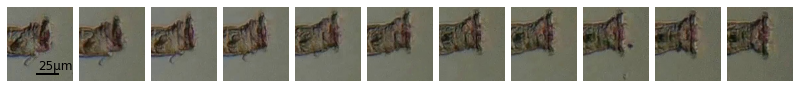

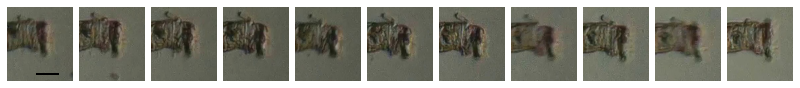

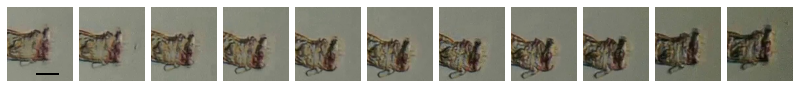

In [50]:
# 4sec video
#plt.rcParams['figure.facecolor'] = 'white'

desired_scale_width = 25  # in mu
scaled_width = desired_scale_width / (pixel_per_real_width)

# Scalebar
scalebar_posxy = [440, 20]


SAVE_FIGURES = True
# frames_upwards = np.arange(0,6,1)
frames_upwards = np.arange(0,11,1)
frames_upwards2 = np.arange(42,53,1)
# frames_middle =[9, 32]
frames_downwards = np.arange(18,29,1)

fig, ax = plt.subplots(1, len(frames_upwards), figsize=(len(frames_upwards),5), layout="constrained")
for nth, idx in enumerate(frames_upwards):
    ax[nth].imshow(rot_imgs[idx])
    ax[nth].set_xlim(350,550);ax[nth].set_ylim(0,225)
    ax[nth].set_axis_off()
ax[0].plot([scalebar_posxy[0], scalebar_posxy[0] + scaled_width], [scalebar_posxy[-1], scalebar_posxy[-1]], "-k", lw=2)
ax[0].text(scalebar_posxy[0] + (scaled_width/20), scalebar_posxy[-1] + 15, f"{desired_scale_width}µm", size="large")
if SAVE_FIGURES: plt.savefig(f"{save_figure_path}-free-swimming-constrained-frames_upwards.jpg", dpi=300)


fig, ax = plt.subplots(1, len(frames_downwards), figsize=(len(frames_downwards),5), layout="constrained")
for nth, idx in enumerate(frames_downwards):
    ax[nth].imshow(rot_imgs[idx] + 15)
    ax[nth].set_xlim(350,550);ax[nth].set_ylim(0,225)
    ax[nth].set_axis_off()
ax[0].plot([scalebar_posxy[0], scalebar_posxy[0] + scaled_width], [scalebar_posxy[-1], scalebar_posxy[-1]], "-k", lw=2)
if SAVE_FIGURES: plt.savefig(f"{save_figure_path}-free-swimming-constrained-frames_downwards.jpg", dpi=300)


fig, ax = plt.subplots(1, len(frames_upwards2), figsize=(len(frames_upwards2),5), layout="constrained")
for nth, idx in enumerate(frames_upwards2):
    ax[nth].imshow(rot_imgs[idx])
    ax[nth].set_xlim(350,550);ax[nth].set_ylim(0,225)
    ax[nth].set_axis_off()
ax[0].plot([scalebar_posxy[0], scalebar_posxy[0] + scaled_width], [scalebar_posxy[-1], scalebar_posxy[-1]], "-k", lw=2)
if SAVE_FIGURES: plt.savefig(f"{save_figure_path}-free-swimming-constrained-frames_upwards2.jpg", dpi=300)

In [ ]:
SAVE_VIDEO = True

vid_size = (rot_imgs[0].shape[1], rot_imgs[0].shape[0])
print(vid_size)
if SAVE_VIDEO:
    video = cv2.VideoWriter(f"{vid_path}{vid_filename}_rotated_video_center_color_.mp4", fourcc=cv2.VideoWriter_fourcc(*"mp4v"), fps=fps, frameSize=vid_size, isColor=True)
    counter = 0

    for frame in rot_imgs:
        #frame = cv2.cvtColor(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        cv2.putText(frame, f"frame{str(counter).zfill(zfill_)}", (0,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        video.write(frame)
        counter += 1

    cv2.destroyAllWindows()
    video.release()

In [ ]:
SAVE_FIGURES = False
highlight_frames = [51, 263, 338]

desired_scale_width = 100  # in mu
scaled_width = desired_scale_width / (pixel_per_real_width)
contour_lw = 2  # contor line width

fig, ax = plt.subplots(figsize=(10,10), nrows=1, ncols=len(highlight_frames), layout="constrained")
longest = 700 # 800 pixels is longest extension
#scalebar_posxy = [350, 200]
ylow, yhigh = 400, 1030
xlow, xhigh = 300, 650
for nth, cframe in enumerate(highlight_frames):
    
    # Centering frame on Centroid
    x, y = df.loc[cframe, "centroid_x"], df.loc[cframe, "centroid_y"]
    #xlow, xhigh = x - (longest / 2), x + (longest / 2)
    #ylow, yhigh = y - (longest / 2), y + (longest / 2)
    
    # Image and contour coloring
    #cimg = cv2.imread(df.loc[cframe, "img_fpath"], 1)
    cimg = rot_imgs[cframe]
    cnt = rot_contours[cframe]  # contour
    ccolors = tuple([c * 255 for c in colors[cframe]])
    
    # Draw contour on image
    cv2.drawContours(cimg, [cnt], 0, ccolors, contour_lw)
    ax[nth].imshow(cimg)
    #plt.xlim(250,750);plt.ylim(300,1000);

    # Axis
    

    ax[nth].set_ylim([ylow, yhigh]); ax[nth].set_xlim([xlow, xhigh])
    ax[nth].invert_yaxis()#ax[nth].set_axis_off()

# Scalebar
#ax[0].plot([scalebar_posxy[0], scalebar_posxy[0] + scaled_width], [scalebar_posxy[-1], scalebar_posxy[-1]], "-k", lw=2)
#ax[0].text(scalebar_posxy[0] + (scaled_width/10), scalebar_posxy[-1] + 25, f"{desired_scale_width}µm", size="x-large")
#plt.tight_layout()

if SAVE_FIGURES: plt.savefig(f"{save_figure_path}-Individual-frames-highlighted_{highlight_frames}.jpg", dpi=300)

In [ ]:
# THIS CAN GO?! OR RE_USE AFTER ROTATION SOMETHOW > CURVATURE
SAVE_FIGURES = False
plt.rcParams["font.size"] = 15

# Select sub_frames for highlighting
highlight_frames = [51, 216, 390]  # only considers the frames shown as subsample
cmcolors = [colors[hl] for hl in highlight_frames]

# Figures Rotifer body shape outline area
plt.figure(figsize=(5.8,4.25))
plt.plot(df["time"], df["area"] / df["area"].max(), "-k", lw=2, label="area")
for cframe, cm_hl in zip(highlight_frames, cmcolors):
    plt.plot(df.loc[cframe, "time"], df.loc[cframe, "area"] / df["area"].max(), "o", color=cm_hl, ms=8)

plt.xlabel("Time (sec)"); plt.ylabel("Max. normalized area");
plt.legend(frameon=False)
plt.tight_layout()
#plt.show()
if SAVE_FIGURES: plt.savefig(f"{save_figure_path}-timedependent-fps_{fps}-area.jpg", dpi=300)

# Figure Double YAxis Rotifer center of mass and displacement
plt.figure(figsize=(6.5,4.25))
ax1 = plt.gca()
ax1.plot(df["time"], df["centroid_x"] * pixel_per_real_width, "-", color="blue", lw=1.5, label="cm$_x$")
ax1.plot(df["time"], df["centroid_y"] * pixel_per_real_width, "-", color="lightblue", lw=1.5, label="cm$_y$")
ax1.set_ylabel("Position of center of mass (µm)"); ax1.set_xlabel("Time (sec)"); 
ax1.spines["left"].set_color("blue")
ax1.yaxis.label.set_color("blue")
ax1.tick_params(axis="y", color="blue")
ax1.set_yticklabels(labels=[int(x) for x in ax1.get_yticks()], color="blue")

ax2 = plt.twinx()
ax2.plot(df["time"], df["centroid_dist"] * pixel_per_real_width, "-k", lw=2)
ax2.spines["right"].set_visible(True)
ax2.spines["right"].set_color("black")

ax2.set_xlabel("Time (sec)"); ax2.set_ylabel("Centroid$_x$$_y$ displacement (µm)");
ax1.legend(frameon=False)
plt.tight_layout()

if SAVE_FIGURES: plt.savefig(f"{save_figure_path}-timedependent-fps_{fps}-centroids.jpg", dpi=300)

In [ ]:
plt.figure(figsize=(5.8,4.25))
plt.plot(df["time"], df["orientation"], "-k", lw=2, label="ori")

## Plot raw images and overlay mask contour

In [ ]:
selected_frames1 = np.arange(260, 265+1, 1)
selected_frames2 = np.arange(335, 340+1, 1)
highlight_frames = [51, 263, 338]
selected_frames1 = np.arange(248, 268+1, 5)
selected_frames1 = np.arange(260, 265+1, 1)
selected_frames2 = np.arange(329, 349+1, 5)
selected_frames2 = np.arange(335, 340+1, 1)
selected_frames = np.append(selected_frames1, selected_frames2)

In [ ]:
SAVE_FIGURES = False # Scale bar > can be moved somewhere else or config for defaults
#plt.rcParams["savefig.bbox"] = "tight"

scalebar_posxy = [400, 200]  # automate or set axis tight and then have a 0-100 scale with corresponding ticks
cxlim = [0, 600]
cylim = [150, 700]

# Prep subsampled data
sub_maskpaths = df["mask_fpath"].tolist()[::every_nth_frame]
#sub_imgpaths = df["img_fpath"].tolist()[::every_nth_frame]
#sub_contours = contour_list[::every_nth_frame]
sub_contours = rot_contours[::every_nth_frame]
# Background white
first_frame = cv2.imread(sub_maskpaths[0])
background = np.ones_like(first_frame) * 255

# Get subsampled contours
for sframe in selected_frames:
    ccolors = colors[sframe]
    ccolors = [ccolors[0] * 255, ccolors[1] * 255, ccolors[2] * 255]
    cv2.drawContours(background, [rot_contours[sframe]], 0, (ccolors[0], ccolors[1], ccolors[2]), 2)

# Figure - Draw contours
plt.figure(figsize=(5,5), layout="constrained")
plt.imshow(background)
plt.ylim([ylow, yhigh]); plt.xlim([xlow, xhigh])
plt.gca().invert_yaxis()
#plt.xlim(cxlim); plt.ylim(cylim);
#plt.axis("off")

# Scalebar
plt.plot([scalebar_posxy[0], scalebar_posxy[0] + scaled_width], [scalebar_posxy[-1], scalebar_posxy[-1]], "-k", lw=3)
plt.text(scalebar_posxy[0] + (scaled_width/10), scalebar_posxy[-1] + 25, f"{desired_scale_width} µm", size="x-large")
plt.tight_layout() # can also set limits in next cell or give back the ax handle?!

if SAVE_FIGURES: plt.savefig(f"{save_figure_path}-fps_{fps}-subsampled_{every_nth_frame}.jpg", dpi=300)

## Segmentation Mask plots over time

In [ ]:
# SAVE_FIGURES = False # Scale bar > can be moved somewhere else or config for defaults
# #plt.rcParams["savefig.bbox"] = "tight"

# scalebar_posxy = [400, 200]  # automate or set axis tight and then have a 0-100 scale with corresponding ticks
# cxlim = [0, 600]
# cylim = [150, 700]

# # Prep subsampled data
# sub_maskpaths = df["mask_fpath"].tolist()[::every_nth_frame]
# #sub_imgpaths = df["img_fpath"].tolist()[::every_nth_frame]
# #sub_contours = contour_list[::every_nth_frame]
# sub_contours = rot_contours[::every_nth_frame]
# # Background white
# first_frame = cv2.imread(sub_maskpaths[0])
# background = np.ones_like(first_frame) * 255

# # Get subsampled contours
# for nth, cnt in enumerate(sub_contours):
#     ccolors = sub_colors[nth]
#     ccolors = [ccolors[0] * 255, ccolors[1] * 255, ccolors[2] * 255]
#     cv2.drawContours(background, [cnt], 0, (ccolors[0], ccolors[1], ccolors[2]), 2)

# # Figure - Draw contours
# plt.figure(figsize=(5,5), layout="constrained")
# plt.imshow(background)
# plt.xlim(cxlim); plt.ylim(cylim);
# #plt.axis("off")

# # Scalebar
# plt.plot([scalebar_posxy[0], scalebar_posxy[0] + scaled_width], [scalebar_posxy[-1], scalebar_posxy[-1]], "-k", lw=3)
# plt.text(scalebar_posxy[0] + (scaled_width/10), scalebar_posxy[-1] + 25, f"{desired_scale_width} µm", size="x-large")
# plt.tight_layout() # can also set limits in next cell or give back the ax handle?!

# if SAVE_FIGURES: plt.savefig(f"{save_figure_path}-fps_{fps}-subsampled_{every_nth_frame}.jpg", dpi=300)

In [ ]:
import matplotlib as mpl
fig = plt.figure(figsize=(3, 1), layout='constrained')
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=int(df["time"].max())), cmap=mpl.cm.brg),
             cax=fig.gca(), orientation='horizontal', label='Time (sec)')
if SAVE_FIGURES: fig.savefig(f"{save_figure_path}-colorbar.jpg", dpi=300)

## Fit ellipse and orient anterior-posterior

In [ ]:
cframe = 216#51

# img
cimg = cv2.cvtColor(cv2.imread(df.loc[cframe, "img_fpath"], 1), cv2.COLOR_BGR2RGB)
h, w = cimg.shape[:2]
center = (w/2, h/2)

# mask
cmask = cv2.imread(df.loc[cframe, "mask_fpath"], 0)

angle = df.loc[cframe, "orientation"]
print(angle)
rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)
cimg_rot = cv2.warpAffine(src=cimg, M=rotate_matrix, dsize=(w, h))


plt.imshow(cimg)
plt.imshow(cmask)
plt.imshow(cimg_rot)
plt.xlim(250,750);plt.ylim(300,800);

In [ ]:
import skimage.morphology as morph

rot_imgs = []
rot_masks = []
rot_thin = []

for nth, row in df.iterrows():
    # Img
    cimg = cv2.cvtColor(cv2.imread(row["img_fpath"], 1), cv2.COLOR_BGR2RGB)
    # Mask
    cmask = cv2.cvtColor(cv2.imread(row["mask_fpath"], 1), cv2.COLOR_BGR2GRAY)
    
    # Rotate
    h, w = cimg.shape[:2]
    center = (w/2, h/2)
    #center = (row["centroid_x"], row["centroid_y"])
    angle = row["orientation"]  # fitted ellipse angle
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)

    # Rotate img, mask, thin
    rot_imgs.append(cv2.warpAffine(src=cimg, M=rotate_matrix, dsize=(w, h)))
    rot_masks.append(cv2.warpAffine(src=cmask, M=rotate_matrix, dsize=(w, h)))
    
    #if  nth % every_nth_frame == 0:
        # Thinning / skeletonize
    # ALREADY THINNED > TAKE CARE OF THIS!!!
    #cthin = morph.thin(cmask).astype("uint8")
        #print(nth, cimg.dtype, cmask.dtype, cthin.dtype)
    #rot_thin.append(cv2.warpAffine(src=cthin, M=rotate_matrix, dsize=(w, h)))


In [ ]:
# counter=0
# for nth, row in df.iterrows():
#     if  nth % every_nth_frame == 0:
#         plt.figure()
#         plt.imshow(rot_imgs[nth])
#         y, x = np.where(rot_thin[counter] != 0)
#         plt.plot(x,y, "-k")
#         counter += 1

# Get rid of the take off > study differently! only mid-swimming 
- start by cutting that video again > using etl tools
- track again
- check skeletion then (morpho.medial_axis(img_as_bool)) can be tried...
- function to align to front (yaxis) and center (xaxis)
- take off clips and swimming clips from same rotifer > check the above graphs whether a measurement can be used to get them out quantitatively?!

In [ ]:
SAVE_SKELETON = False
if SAVE_SKELETON:
    np.save(f"skeletonized{vid_filename}", rot_thin)
else:
    rot_thin = np.load(f"skeletonized{vid_filename}.npy")

# rot_thin_loaded

In [ ]:
selected_frames1 = np.arange(248, 268+1, 5)
selected_frames1 = np.arange(260, 265+1, 1)
selected_frames2 = np.arange(329, 349+1, 5)
selected_frames2 = np.arange(335, 340+1, 1)
selected_frames = np.append(selected_frames1, selected_frames2)

window_size = 10

plt.figure(figsize=(8, 8))
for sframe in selected_frames:  # rot_thin[::2]for nth, line in enumerate(rot_thin_loaded):
    line = rot_thin[sframe]
    y, x = np.where(line != 0)
    
    #y = y - y.min()
    y = y - y.max()# idx = y >= 25
    #y_smooth = np.convolve(y, np.ones(window_size)/window_size, mode='valid')
    # x = x[idx] - x[idx].mean()
    # y = y[idx]
    #plt.plot(x + (nth*50), y, "-", color=colors[nth])
    #plt.plot(x[window_size-1:], y_smooth, "-", color=colors[sframe], lw=2)
    plt.plot(x, y * -1, "-", color=colors[sframe], lw=2)

plt.xlim(460,550);plt.ylim(-5,370);
# window_size = 10
# y_smooth = np.convolve(y, np.ones(window_size)/window_size, mode='valid')
# plt.plot(x, y, "-r")
# plt.plot(x[window_size-1:], y_smooth, "-k")

In [ ]:
SAVE_FIGURES = False
#rot_thin[0]
fig, ax = plt.subplots(layout="constrained")
for nth, line in enumerate(rot_thin):  # for nth, line in enumerate(rot_thin_loaded):
    y, x = np.where(line != 0)
    y = y - y.min()
    idx = y >= 25
    x = x[idx] - x[idx].mean()
    y = y[idx]
    ax.plot(x, y, "-", color=colors[nth])
    #ax[0].invert_yaxis()

ax.set(xlim=(-25,25), ylim=(-20, 450))
if SAVE_FIGURES: fig.savefig(f"{save_figure_path}-skeleton.jpg", dpi=300)

In [ ]:
#%matplotlib widget
fig, ax = plt.subplots(layout="constrained")
for nth, line in enumerate(rot_thin):  # for nth, line in enumerate(rot_thin_loaded):
    y, x = np.where(line != 0)
    y = y - y.min()
    idx = y >= 25
    x = x[idx] - x[idx].mean()
    y = y[idx]
    ax.plot(x, y, "-", color=colors[nth])
